# Import Packages

In [33]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle

# Import Data

In [2]:
X = pd.read_csv('data/train_values.csv', index_col='patient_id')

In [3]:
X.head()

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
patient_id,,,,,,,,,,,,,
0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0
ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0
yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1
l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0
oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0


We can see from the above output that our dataset have three types of features catagorical, numerical and binary features. We will separate those features.

In [4]:
numerical_features = ['slope_of_peak_exercise_st_segment', 
                      'resting_blood_pressure', 
                      'num_major_vessels',
                      'fasting_blood_sugar_gt_120_mg_per_dl',
                      'serum_cholesterol_mg_per_dl',
                      'oldpeak_eq_st_depression',
                      'age',
                      'max_heart_rate_achieved']

categorical_features = ['thal',
                        'chest_pain_type', 
                        'resting_ekg_results']

binary_features = ['sex',
                   'exercise_induced_angina']

# Import label

In [5]:
y = pd.read_csv('data/train_labels.csv', index_col='patient_id')['heart_disease_present']

# Correlation plot for features

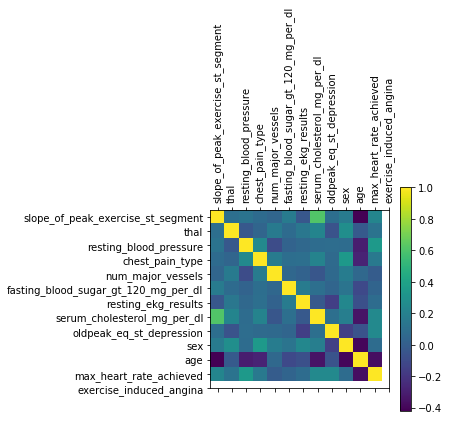

In [6]:
plt.matshow(X.corr())
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
plt.yticks(range(X.shape[1]), X.columns)
plt.colorbar()
plt.show();

Above plot shows the correlation between the different features of the given data. More bluish means there is low correlation and yellowish means there is a high correlation.

Now, let us see the violin plots of the all of the features. From these plots we can determine that how that particular feture is going to affect the label. If the violin plot look similar it means that feature is not much significant in the detection of the disease.

All of the above plots can be made at once just by using the following code.

# Transformers

As we have seen that our data has some categorical features which we need to transform into the numerical values. We have to use the column transformer for that job. I have illustrated below, what it returns after executing.

In [7]:
class ColumnSelectTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        return X[self.columns]
    
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.labelers = {col: LabelEncoder().fit(X[col]) for col in X}
        return self
    
    def transform(self, X):
        return pd.DataFrame({col: self.labelers[col].transform(X[col])
                            for col in X})

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [15]:
import category_encoders as ce
encoder = ce.HelmertEncoder(cols =categorical_features, drop_invariant=True )
dfh = encoder.fit_transform(X_train[categorical_features])
df = pd.concat([X_train, dfh], axis = 1)

In [16]:
df.head()

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,thal_0,thal_1,chest_pain_type_0,chest_pain_type_1,chest_pain_type_2,resting_ekg_results_0,resting_ekg_results_1
patient_id,,,,,,,,,,,,,,,,,,,,
bthqr4,1,normal,150,1,0,1,2,283,1.0,0,58,162,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
hltlsl,2,reversible_defect,142,4,3,0,2,309,0.0,1,45,147,1,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0
v52zcs,2,reversible_defect,128,4,2,0,2,259,3.0,1,58,130,1,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0
jscmp8,2,normal,134,2,0,0,0,271,0.0,0,49,162,0,-1.0,-1.0,0.0,2.0,-1.0,1.0,-1.0
jhdvtb,1,normal,106,4,2,0,0,223,0.3,0,67,142,0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0


### Illustration of the above transformer

In [17]:
tahl_pipe = Pipeline([
    ('cst', ColumnSelectTransformer(["thal"])),
    ('cle', CustomLabelEncoder()),
    ('ohe', OneHotEncoder(categories = "auto",sparse=False))
])

In [18]:
tahl_pipe.fit_transform(X)[0:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

This array has three columns becuase it has three unique values which can be verified by the following code.

In [19]:
len(X["thal"].unique())

3

The __thal__ column in the dataframe is converted into array as shown above. The interpretation of the above array is that <br/> __normal = [0. 1. 0.], reversible_defect = [0. 0. 1.]__ and __fixed_defect = [1. 0. 0.]__.

# Logistic Regression

In [20]:
# For categorical features
cat_pipe = Pipeline([
    ('cst', ColumnSelectTransformer(categorical_features)),
    ('cle', CustomLabelEncoder()),
    ('ohe', OneHotEncoder(sparse=False))
])

# For features we don't want to transform
passthrough_pipe = Pipeline([
    ('cst', ColumnSelectTransformer(numerical_features + binary_features))
])

# combining the above pipelines
feat_u = FeatureUnion([
    ('cat_pipe', cat_pipe),
    ('passthrough_pipe', passthrough_pipe)
])

In [21]:
# combining the pipelines and the logistic regression
full_model = Pipeline([
    ('feat_u', feat_u),
    ('lr', LogisticRegression())
])

In [22]:
list(X_train.columns)

['slope_of_peak_exercise_st_segment',
 'thal',
 'resting_blood_pressure',
 'chest_pain_type',
 'num_major_vessels',
 'fasting_blood_sugar_gt_120_mg_per_dl',
 'resting_ekg_results',
 'serum_cholesterol_mg_per_dl',
 'oldpeak_eq_st_depression',
 'sex',
 'age',
 'max_heart_rate_achieved',
 'exercise_induced_angina']

In [23]:
X_train.exercise_induced_angina.unique()

array([0, 1], dtype=int64)

In [24]:
full_model.fit(X_train, y_train)

C:\Users\Surjeet\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('feat_u',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('cat_pipe',
                                                 Pipeline(memory=None,
                                                          steps=[('cst',
                                                                  ColumnSelectTransformer(columns=['thal',
                                                                                                   'chest_pain_type',
                                                                                                   'resting_ekg_results'])),
                                                                 ('cle',
                                                                  CustomLabelEncoder()),
                                                                 ('ohe',
                                                                  OneHotEncoder(categories='auto',
                   

In [27]:
#X_test = X_test.reset_index().drop("patient_id", axis = 1)
x = pd.DataFrame(X_train.iloc[0]).T
x.reset_index(drop = True, inplace = True)
x

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
0,1,normal,150,1,0,1,2,283,1,0,58,162,0


In [28]:
# predicting the probability for the given data
columns = list(X_train.columns)
input = pd.DataFrame([2,"normal",130,2,0,0,2,234,0.6,0,45,175,0]).T
input.columns = columns
input
#y_pred = full_model.predict_proba(pd.DataFrame([3,"normal",108,0,2,0,2,2.5,2,0,25,120,0]).T)
#y_pred = full_model.predict_proba(x)
#y_pred[0][0]

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
0,2,normal,130,2,0,0,2,234,0.6,0,45,175,0


In [29]:
# saving the model as pickle file
pickle.dump(full_model, open('model.pkl','wb'))

In [30]:
loaded_model = pickle.load(open("model.pkl","rb"))

In [31]:
loaded_model.predict_proba(input)

array([[0.9582607, 0.0417393]])

In [34]:
cols = ["Thresholds",'TP', 'FP', 'TN','FN']
lst = []
for i in np.arange(0,1.1,0.1):
    y_pred = np.where(full_model.predict_proba(X_test)[:,1]>i,1,0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    lst.append([round(i,1),tp,fp,tn,fn])
confusion_result = pd.DataFrame(lst, columns=cols)

In [35]:
confusion_result.head()

,Thresholds,TP,FP,TN,FN
0,0.0,15,21,0,0
1,0.1,12,10,11,3
2,0.2,11,7,14,4
3,0.3,11,4,17,4
4,0.4,10,3,18,5


In [36]:
def calculate_metrics(results):
    roc = pd.DataFrame(index = results['Thresholds'], columns=['recall', 'precision', 'f1', 'tpr', 'fpr'])
    
    for i in results.iterrows():
        
        t, tp, fp,tn, fn = i[1]
        #print(t, tp, fp,tn, fn)
        #assert tp + fp + tn + fn == 100, 'Patients must add up to 100'
        
        recall = tp / (tp + fn)
        
        if tp == fp == 0:
            precision = 0
            true_positive_rate = 0
        
        else:
            precision = tp / (tp + fp)
            true_positive_rate = tp / (tp + fn)
            
        if precision == recall == 0:
            f1 = 0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
        
        
        false_positive_rate = fp / (fp + tn)
        
        roc.ix[t, 'recall'] = recall
        roc.ix[t, 'precision'] = precision
        roc.ix[t, 'f1'] = f1
        roc.ix[t, 'tpr'] = true_positive_rate
        roc.ix[t, 'fpr'] = false_positive_rate
    
    return roc

In [37]:
roc = calculate_metrics(confusion_result)
roc.reset_index()

C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: 
.ix is deprecated

,Thresholds,recall,precision,f1,tpr,fpr
0,0.0,1,0.416667,0.588235,1,1
1,0.1,0.8,0.545455,0.648649,0.8,0.47619
2,0.2,0.733333,0.611111,0.666667,0.733333,0.333333
3,0.3,0.733333,0.733333,0.733333,0.733333,0.190476
4,0.4,0.666667,0.769231,0.714286,0.666667,0.142857
5,0.5,0.666667,0.833333,0.740741,0.666667,0.0952381
6,0.6,0.6,0.818182,0.692308,0.6,0.0952381
7,0.7,0.4,0.857143,0.545455,0.4,0.047619
8,0.8,0.4,0.857143,0.545455,0.4,0.047619
9,0.9,0.4,1,0.571429,0.4,0


Populating the interactive namespace from numpy and matplotlib


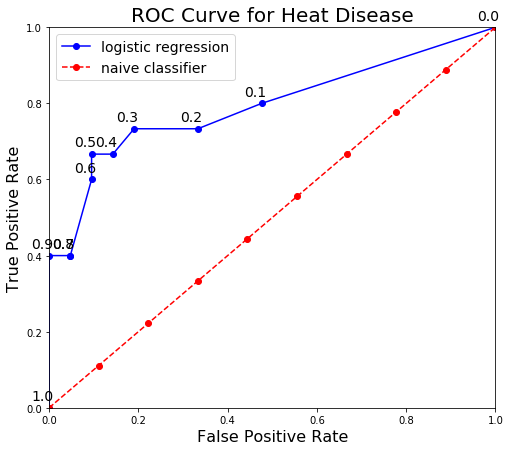

In [40]:
%pylab inline
figsize(8, 7)
plt.style.use('seaborn-dark-palette')
thresholds = [str(t) for t in confusion_result['Thresholds']]
plt.plot(roc['fpr'], roc['tpr'], 'bo-', label = 'logistic regression');
plt.plot(list(np.linspace(0, 1, num = 10)), list(np.linspace(0, 1, num = 10)), 'ro--', label = 'naive classifier');
for x, y, s in zip(roc['fpr'], roc['tpr'], thresholds):
    plt.text(x - 0.04,y + 0.02, s, fontdict={'size': 14});

plt.legend(prop={'size':14})
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate', size = 16); plt.xlabel('False Positive Rate', size = 16);
plt.title('ROC Curve for Heat Disease', size = 20);

In [41]:
y_pred = np.where(full_model.predict_proba(X_test)[:,1]>0.22,1,0)
pd.crosstab(y_test, y_pred)
#roc_curve()

col_0,0,1
heart_disease_present,,
0,15,6
1,4,11


In [42]:
y_pred = np.where(full_model.predict_proba(X_test)[:,1]>0.22,1,0)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("TN:",tn,"FP:",fp,"FN:",fn,"TP:",tp)
recall = round(tp/(tp+fn),2)
print("True positive rate:",recall)
print("False positive rate:",round(fp/(fp+tn),2))
precision = round(tp/(tp+fp),2)
print("Precision:",precision)
print("f-measure:",round(2*recall*precision/(recall+precision),2))

TN: 15 FP: 6 FN: 4 TP: 11
True positive rate: 0.73
False positive rate: 0.29
Precision: 0.65
f-measure: 0.69


81% of the positive cases are predicted as positive at the cost of true negative.

In [43]:
print("predicted",y_pred)
print("actual   ",np.array(y_test))

predicted [0 0 0 0 1 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 1 0 1 1 1 0 1 1 1 0 0 1 0]
actual    [1 0 1 0 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0]


Lesser the value of the log loss fuction better our model is.

Now importing the test data provided by the drivedata.org as __X_test__.

In [44]:
X_new_test = pd.read_csv('data/test_values.csv', index_col='patient_id')
X_new_test.head()

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
patient_id,,,,,,,,,,,,,
olalu7,2,reversible_defect,170,1,0,0,2,288,0.2,1,59,159,0
z9n6mx,1,normal,138,4,0,0,0,183,1.4,0,35,182,0
5k4413,2,reversible_defect,120,4,0,0,2,177,2.5,1,43,120,1
mrg7q5,1,normal,102,3,1,0,0,318,0.0,0,60,160,0
uki4do,2,normal,138,4,1,0,2,166,3.6,1,61,125,1


Predicting the label probability ( probability of presence of heart disease) for the test data.

In [45]:
y_pred_test = np.where(full_model.predict_proba(X_new_test)[:,1]>0.22,1,0)

In [46]:
X_test.head(2)

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
patient_id,,,,,,,,,,,,,
fz84ac,1,normal,160,1,0,0,2,273,0.0,1,59,125,0
h3uzv8,1,normal,155,3,0,0,0,269,0.8,0,65,148,0


In [47]:
y_ans = y_pred_test

Exporting the prediction as csv file.

In [48]:
submission = pd.read_csv('data/submission_format.csv')
submission.heart_disease_present = y_ans
submission.to_csv('2019-08-18_submission.csv', index=False)

### Predicting the new instance

To predict the new instance one need to create a dataframe and pass to the model. To dignose the patient one has to put the values of the different column provided in the dataframe. Below is an example of it.

In [49]:
# putting the values for the different for the patient to be dignose

df = pd.DataFrame({'slope_of_peak_exercise_st_segment':[2], 
                   'thal':['normal'], 
                   'resting_blood_pressure':[180],
                   'chest_pain_type':[3], 
                   'num_major_vessels':[0],
                   'fasting_blood_sugar_gt_120_mg_per_dl':[1], 
                   'resting_ekg_results':[1],
                   'serum_cholesterol_mg_per_dl':[280], 
                   'oldpeak_eq_st_depression':[1.6], 
                   'sex':[1], 
                   'age':[65],
                   'max_heart_rate_achieved':[130], 
                   'exercise_induced_angina':[1]}) 

# predicitng the probability
instance = np.where(full_model.predict_proba(df)[:,1]>0.22,1,0)
#instance[0]
print('The patient has', round(instance[0],2), 'probability of having heart disease')

The patient has 1 probability of having heart disease


# Reduced Logistic Regression

Here we are reducing the features which are less important. We will select only three columns 

In [50]:
reduced_cols = ['num_major_vessels',
                'slope_of_peak_exercise_st_segment',
                'max_heart_rate_achieved',
                'exercise_induced_angina',
                'age',
                'oldpeak_eq_st_depression',]

numerical_features = ['slope_of_peak_exercise_st_segment', 
                      'resting_blood_pressure', 
                      'num_major_vessels',
                      'fasting_blood_sugar_gt_120_mg_per_dl',
                      'serum_cholesterol_mg_per_dl',
                      'oldpeak_eq_st_depression',
                      'age',
                      'max_heart_rate_achieved']

categorical_features = ['thal',
                        'chest_pain_type', 
                        'resting_ekg_results']

binary_features = ['sex',
                   'exercise_induced_angina']

In [51]:
categorical_features = list(set(categorical_features).intersection(set(reduced_cols)))
numerical_features = list(set(numerical_features).intersection(set(reduced_cols)))
binary_features = list(set(binary_features).intersection(set(reduced_cols)))

In [52]:


LogReg = LogisticRegression()
# combining the pipelines and the logistic regression
#reduce_model = Pipeline([
 #   ('feat_u', feat_u),
  #  ('lr', LogisticRegression())
#])
LogReg.fit(X_train[reduced_cols],y_train)

#y_pred = simple_lr.predict_proba(X_test[reduced_cols])


#log_loss(y_test, y_pred, labels = None)

C:\Users\Surjeet\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [53]:
list(X_train[reduced_cols].columns)

['num_major_vessels',
 'slope_of_peak_exercise_st_segment',
 'max_heart_rate_achieved',
 'exercise_induced_angina',
 'age',
 'oldpeak_eq_st_depression']

In [54]:
x = pd.DataFrame(X_train[reduced_cols].iloc[0]).T
x

,num_major_vessels,slope_of_peak_exercise_st_segment,max_heart_rate_achieved,exercise_induced_angina,age,oldpeak_eq_st_depression
bthqr4,0.0,1.0,162.0,0.0,58.0,1.0


In [55]:
LogReg.predict(x)

array([0], dtype=int64)

In [56]:
y_pred = LogReg.predict_proba(X_test[reduced_cols])
y_pred

array([[0.87528715, 0.12471285],
       [0.91138372, 0.08861628],
       [0.88967652, 0.11032348],
       [0.39998943, 0.60001057],
       [0.21375965, 0.78624035],
       [0.17261235, 0.82738765],
       [0.02003263, 0.97996737],
       [0.94955993, 0.05044007],
       [0.68868774, 0.31131226],
       [0.94430885, 0.05569115],
       [0.90732566, 0.09267434],
       [0.82880619, 0.17119381],
       [0.63522555, 0.36477445],
       [0.82912535, 0.17087465],
       [0.06335538, 0.93664462],
       [0.87796629, 0.12203371],
       [0.69028842, 0.30971158],
       [0.85507047, 0.14492953],
       [0.77674664, 0.22325336],
       [0.74971067, 0.25028933],
       [0.87228269, 0.12771731],
       [0.94931348, 0.05068652],
       [0.48735145, 0.51264855],
       [0.80390673, 0.19609327],
       [0.91344196, 0.08655804],
       [0.39018128, 0.60981872],
       [0.03476396, 0.96523604],
       [0.15231695, 0.84768305],
       [0.69154958, 0.30845042],
       [0.38248388, 0.61751612],
       [0.

In [57]:
pickle.dump(LogReg, open('log_reg.pkl','wb'))

In [58]:
cols = ["Thresholds",'TP', 'FP', 'TN','FN']
lst = []
for i in np.arange(0,1.1,0.05):
    y_pred = np.where(LogReg.predict_proba(X_test[reduced_cols])[:,1]>i,1,0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    lst.append([round(i,1),tp,fp,tn,fn])
confusion_result = pd.DataFrame(lst, columns=cols)

In [59]:
roc = calculate_metrics(confusion_result)
roc.reset_index()

C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: 
.ix is deprecated

,Thresholds,recall,precision,f1,tpr,fpr
0,0.0,1,0.416667,0.588235,1,1
1,0.0,1,0.416667,0.588235,1,1
2,0.1,0.933333,0.5,0.651163,0.933333,0.666667
3,0.2,0.733333,0.611111,0.666667,0.733333,0.333333
4,0.2,0.733333,0.611111,0.666667,0.733333,0.333333
5,0.2,0.733333,0.611111,0.666667,0.733333,0.333333
6,0.3,0.733333,0.647059,0.6875,0.733333,0.285714
7,0.4,0.6,0.75,0.666667,0.6,0.142857
8,0.4,0.6,0.75,0.666667,0.6,0.142857
9,0.4,0.6,0.75,0.666667,0.6,0.142857


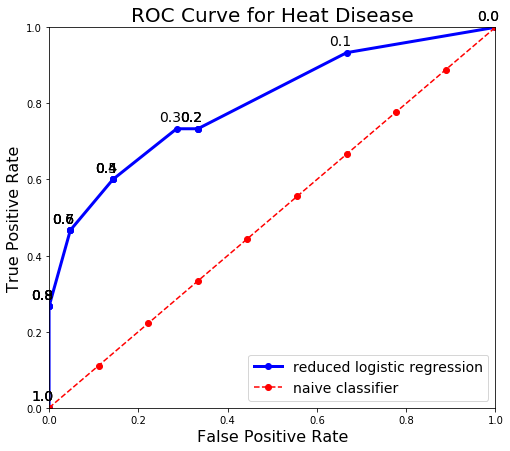

In [60]:
figsize(8,7)
plt.style.use('seaborn-dark-palette')
thresholds = [str(t) for t in confusion_result['Thresholds']]
plt.plot(roc['fpr'], roc['tpr'], 'bo-', label = 'reduced logistic regression',lw = 3);
plt.plot(list(np.linspace(0, 1, num = 10)), list(np.linspace(0, 1, num = 10)), 'ro--', label = 'naive classifier');
for x, y, s in zip(roc['fpr'], roc['tpr'], thresholds):
    plt.text(x - 0.04,y + 0.02, s, fontdict={'size': 14});

plt.legend(prop={'size':14})
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate', size = 16); plt.xlabel('False Positive Rate', size = 16);
plt.title('ROC Curve for Heat Disease', size = 20);

In [61]:
#for i in np.arange(0.2,0.3,0.01):
 #   y_pred = np.where(LogReg.predict_proba(X_test[reduced_cols])[:,1]>i,1,0)
  #  print("Threshold:",i)
   # print(confusion_matrix(y_test,y_pred))

In [62]:
y_pred = np.where(LogReg.predict_proba(X_test[reduced_cols])[:,1]>0.22,1,0)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("TN:",tn,"FP:",fp,"FN:",fn,"TP:",tp)
recall = round(tp/(tp+fn),2)
print("True positive rate:",recall)
print("False positive rate:",round(fp/(fp+tn),2))
precision = round(tp/(tp+fp),2)
print("Precision:",precision)
print("f-measure:",round(2*recall*precision/(recall+precision),2))

TN: 13 FP: 8 FN: 4 TP: 11
True positive rate: 0.73
False positive rate: 0.38
Precision: 0.58
f-measure: 0.65


Still the true positive rate of the actual patients is 81%. There is no improvement in the model even after reducing the parameters. So we have to use some advanced model.

In [63]:
# exporting the file into required format
submission = pd.read_csv('data/submission_format.csv')
submission.heart_disease_present = y_pred_test
submission.to_csv('2019-08-18_reduced_submission.csv', index=False)

In [64]:
param_grid = {'max_depth': range(3,10),
              'min_samples_split': range(3,11,2),
              'min_samples_leaf': range(3,11,2)}

gs = GridSearchCV(RandomForestClassifier(),
                  param_grid=param_grid,
                  n_jobs=-1,
                  cv=3,
                  verbose=1)

In [65]:
gs.fit(X_train[reduced_cols], y_train)

Fitting 3 folds for each of 112 candidates, totalling 336 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 336 out of 336 | elapsed:   48.8s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [66]:
gs.best_params_

{'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 3}

In [67]:
y_pred = gs.predict_proba(X_test[reduced_cols])

In [68]:
cols = ["Thresholds",'TP', 'FP', 'TN','FN']
lst = []
for i in np.arange(0,1.1,0.05):
    y_pred = np.where(gs.predict_proba(X_test[reduced_cols])[:,1]>i,1,0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    lst.append([round(i,1),tp,fp,tn,fn])
confusion_result = pd.DataFrame(lst, columns=cols)

In [69]:
roc = calculate_metrics(confusion_result)
roc = roc.reset_index()

C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Surjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: 
.ix is deprecated

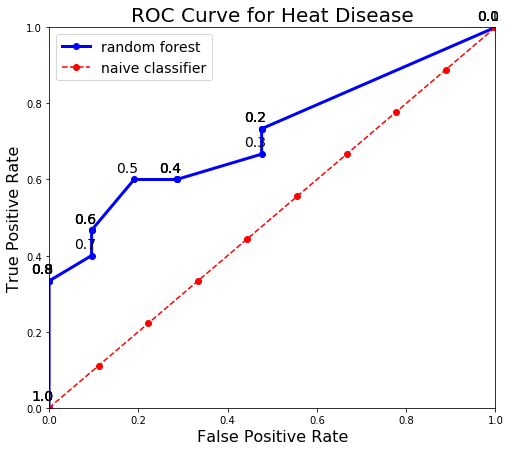

In [70]:
figsize(8, 7)
plt.style.use('seaborn-dark-palette')
thresholds = [str(t) for t in confusion_result['Thresholds']]
plt.plot(roc['fpr'], roc['tpr'], 'bo-', label = 'random forest',lw = 3);
plt.plot(list(np.linspace(0, 1, num = 10)), list(np.linspace(0, 1, num = 10)), 'ro--', label = 'naive classifier');
for x, y, s in zip(roc['fpr'], roc['tpr'], thresholds):
    plt.text(x - 0.04,y + 0.02, s, fontdict={'size': 14});

plt.legend(prop={'size':14})
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate', size = 16); plt.xlabel('False Positive Rate', size = 16);
plt.title('ROC Curve for Heat Disease', size = 20);

In [72]:
for i in np.arange(0.2,0.3,0.01):
    y_pred = np.where(gs.predict_proba(X_test[reduced_cols])[:,1]>i,1,0)
    print("Threshold:",round(i,2))
    print(confusion_matrix(y_test,y_pred))

Threshold: 0.2
[[ 9 12]
 [ 3 12]]
Threshold: 0.21
[[ 9 12]
 [ 3 12]]
Threshold: 0.22
[[ 9 12]
 [ 3 12]]
Threshold: 0.23
[[10 11]
 [ 3 12]]
Threshold: 0.24
[[11 10]
 [ 3 12]]
Threshold: 0.25
[[11 10]
 [ 4 11]]
Threshold: 0.26
[[11 10]
 [ 4 11]]
Threshold: 0.27
[[11 10]
 [ 5 10]]
Threshold: 0.28
[[11 10]
 [ 5 10]]
Threshold: 0.29
[[11 10]
 [ 5 10]]


Here our main goal is to reduce the false negative because none of the patient should be deteced as negative if patient has the disease in actual. In parallel, we also have to minimize the false positive so that the minimum number of the patient detected as positve when they do not have disease actually.

In [73]:
y_pred = np.where(gs.predict_proba(X_test[reduced_cols])[:,1]>0.22,1,0)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("TN:",tn,"FP:",fp,"FN:",fn,"TP:",tp)
recall = round(tp/(tp+fn),2)
print("True positive rate:",recall)
print("False positive rate:",round(fp/(fp+tn),2))
precision = round(tp/(tp+fp),2)
print("Precision:",precision)
print("f-measure:",round(2*recall*precision/(recall+precision),2))

TN: 9 FP: 12 FN: 3 TP: 12
True positive rate: 0.8
False positive rate: 0.57
Precision: 0.5
f-measure: 0.62


In [74]:
confusion_matrix(y_test,y_pred)
#log_loss(y_test, y_pred, labels = None)

array([[ 9, 12],
       [ 3, 12]], dtype=int64)

## Test Values

In [75]:
X_test = pd.read_csv('data/test_values.csv', index_col='patient_id')

In [77]:
submission = pd.read_csv('data/submission_format.csv')

In [78]:
submission.heart_disease_present = y_ans

In [79]:
submission.to_csv('2019-08-18_submission.csv', index=False)

## summary

logistic regression
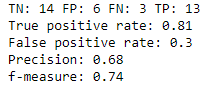

reduced logistic regression
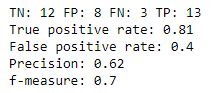

random forest
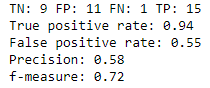

After analyzing all of the three models, we conclude that the random forest with the threshold probability 0.22 is working. It increases not only the true positives but also reduces the false positive.